<p align="center">
  <img src="https://media.istockphoto.com/id/1135912032/photo/respiratory-system.jpg?s=2048x2048&w=is&k=20&c=9vBNs47uX_gaY32HKTzgO4t2I-gaYIV3LA7xZAtM1CA=" style="width:100%; max-width:900px; height:180px; object-fit:cover; border-radius:10px;"/>
</p>
<div style="text-align:center;">
  <h1 style="color:Gray; display:inline-block; margin:0;; size:2.5em">Lung Life</h1><br>
  <h1 style="color:Gray; display:inline-block; margin:0;">Aplicacion movil para diagnostico temprano de cancer pulmonar</h1>
  <p>
    <b>LungLife | Machine Learning | CRISP-DM</b><br>
    <span style="font-size:1.1em;">Análisis y predicción de la salud pulmonar utilizando machine learning.</span>
  </p>
</div>

# FASE 5: Evaluación (CRISP-DM)

## Propósito de la Fase de Evaluación

En esta quinta fase del proceso CRISP-DM, evaluamos exhaustivamente los modelos desarrollados en la fase de modelado para determinar su calidad y eficacia en resolver los objetivos de negocio. Esta fase es crucial para validar que los modelos no solo funcionan técnicamente, sino que también proporcionan **valor real, seguridad clínica y responsabilidad ética** para su despliegue en el MVP.

### Objetivos de esta Fase

1. **Validación Clínica:** Verificar predicciones con casos de prueba médicos conocidos
2. **Análisis de Errores:** Auditar Falsos Negativos y Falsos Positivos con plan de mitigación
3. **Auditoría de Interpretabilidad (XAI):** Verificar coherencia de factores de riesgo con literatura médica
4. **Métricas Finales de Negocio:** Traducir métricas técnicas a impactos potenciales en salud
5. **Criterios de Aprobación (Go/No-Go):** Lista de verificación final para autorizar paso a producción

### Contexto Regional de LungLife

El modelo está orientado a poblaciones de riesgo en:
- **Antofagasta:** Exposición a arsénico y actividad minera
- **Magallanes:** Condiciones climáticas extremas y aislamiento geográfico
- **Región Metropolitana:** Contaminación ambiental y alta densidad poblacional

| Actividad | Descripción | Entregables |
|-----------|-------------|-------------|
| Validación clínica | Validar predicciones con casos de prueba médicos | Reporte de validación |
| Análisis de errores | Identificar falsos positivos/negativos críticos | Plan de mitigación |
| Evaluación de interpretabilidad | Verificar que factores de riesgo sean clínicamente coherentes | Informe de XAI |
| Test de conjunto (test set) | Evaluación final en datos no vistos | Métricas finales |
| Aprobación del modelo | Go/No-Go decision para deployment | Documento de aprobación |

In [1]:
# =============================================================================
# CONFIGURACIÓN E IMPORTACIONES
# =============================================================================

# Instalación de dependencias
%pip install scikit-learn xgboost shap imbalanced-learn -q

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# Librerías del sistema
import sys
import os
from pathlib import Path
from datetime import datetime
import hashlib
import json

# Librerías de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold
)

# Scikit-learn: Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, average_precision_score
)

# XGBoost
try:
    import xgboost as xgb
    print("[OK] XGBoost disponible")
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "-q"])
    import xgboost as xgb
    print("[OK] XGBoost instalado")

# SHAP para interpretabilidad
try:
    import shap
    print("[OK] SHAP disponible")
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap
    print("[OK] SHAP instalado")

# Persistencia
import joblib
import pickle

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("=" * 60)
print("CONFIGURACIÓN COMPLETADA - FASE 5: EVALUATION")
print("=" * 60)
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"SHAP: {shap.__version__}")

Note: you may need to restart the kernel to use updated packages.
[OK] XGBoost disponible
[OK] SHAP disponible
CONFIGURACIÓN COMPLETADA - FASE 5: EVALUATION
Python: 3.12.10
Pandas: 3.0.0
NumPy: 2.3.5
XGBoost: 3.1.3
SHAP: 0.50.0


In [2]:
# =============================================================================
# CARGA DE DATOS Y MODELO FINAL
# =============================================================================

# Definir rutas
DATA_PROCESSED = Path('../data/processed')
MODELS_DIR = Path('../models')
REPORTS_DIR = Path('../reports')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("CARGA DE DATASETS Y MODELO FINAL")
print("=" * 60)

# Cargar datasets de test (evaluación final)
X_test = pd.read_csv(DATA_PROCESSED / 'X_test_processed.csv')
y_test = pd.read_csv(DATA_PROCESSED / 'y_test.csv').values.ravel()

# Cargar datasets de validación (para análisis adicional)
X_val = pd.read_csv(DATA_PROCESSED / 'X_val_processed.csv')
y_val = pd.read_csv(DATA_PROCESSED / 'y_val.csv').values.ravel()

# Cargar nombres de features
feature_names = pd.read_csv(DATA_PROCESSED / 'feature_columns.csv')['feature_name'].tolist()

# Cargar modelo final
BEST_MODEL = joblib.load(MODELS_DIR / 'lung_cancer_classifier.joblib')

# Cargar label encoders
label_encoders = joblib.load(MODELS_DIR / 'label_encoders.joblib')

# Cargar configuración del modelo
with open(MODELS_DIR / 'model_config.json', 'r', encoding='utf-8') as f:
    model_config = json.load(f)

BEST_MODEL_NAME = model_config['model_name']

print(f"\n[MODELO] Cargado: {BEST_MODEL_NAME}")
print(f"   Tipo: {model_config['model_type']}")
print(f"   Versión: {model_config['version']}")
print(f"   Creado: {model_config['created_at']}")

print(f"\n[TEST] Conjunto de Prueba:")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {len(y_test)} | Clase 0: {(y_test == 0).sum():,} | Clase 1: {(y_test == 1).sum():,}")

print(f"\n[INFO] Features: {len(feature_names)}")

CARGA DE DATASETS Y MODELO FINAL

[MODELO] Cargado: Random Forest
   Tipo: RandomForestClassifier
   Versión: 1.0.0
   Creado: 2026-01-26T00:03:25.811926

[TEST] Conjunto de Prueba:
   X_test: (45000, 29)
   y_test: 45000 | Clase 0: 22,523 | Clase 1: 22,477

[INFO] Features: 29


In [3]:
# =============================================================================
# PREPROCESAMIENTO DE DATOS PARA EVALUACIÓN
# =============================================================================

print("=" * 60)
print("PREPROCESAMIENTO DE DATOS PARA EVALUACIÓN")
print("=" * 60)

# Identificar columnas categóricas
categorical_cols = X_test.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
print(f"Columnas categóricas a codificar: {categorical_cols}")

# Crear copias para evitar modificar datos originales
X_test_encoded = X_test.copy()
X_val_encoded = X_val.copy()

# Codificar columnas categóricas usando los encoders guardados
for col in categorical_cols:
    if col in label_encoders:
        le = label_encoders[col]
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        X_test_encoded[col] = X_test_encoded[col].astype(str).map(mapping).fillna(-1).astype(int)
        X_val_encoded[col] = X_val_encoded[col].astype(str).map(mapping).fillna(-1).astype(int)

print(f"\n[OK] Datos codificados exitosamente")
print(f"   X_test_encoded: {X_test_encoded.shape}")
print(f"   X_val_encoded: {X_val_encoded.shape}")

PREPROCESAMIENTO DE DATOS PARA EVALUACIÓN
Columnas categóricas a codificar: ['Gender', 'Smoking_History', 'Occupation', 'Residential_Area', 'Physical_Activity_Level', 'Dietary_Habits', 'Comorbidities', 'Smoking_Risk_Level']

[OK] Datos codificados exitosamente
   X_test_encoded: (45000, 29)
   X_val_encoded: (45000, 29)


---

## 1. Sistema de Gestión de Modelos (ModelManager)

### 1.1 Clase ModelManager

Sistema de gestión de modelos de Machine Learning que:
- **Guarda automáticamente** modelos con nombre único basado en parámetros y timestamp
- **Verifica antes de entrenar** si existe un modelo con los mismos parámetros
- **Guarda metadata** incluyendo parámetros, métricas y fecha de entrenamiento
- **Permite comparar** métricas entre diferentes versiones

In [4]:
# =============================================================================
# 1.2 CLASE MODELMANAGER - SISTEMA DE GESTIÓN DE MODELOS
# =============================================================================

class ModelManager:
    """
    Sistema de gestión de modelos de Machine Learning.
    
    Funcionalidades:
    - Guardar modelos con nombre único basado en parámetros y timestamp
    - Verificar si existe un modelo con los mismos parámetros antes de entrenar
    - Guardar metadata junto al modelo (parámetros, métricas, fecha)
    - Listar y comparar modelos guardados
    - Obtener el mejor modelo según una métrica específica
    
    Estructura de archivos:
    models/
    ├── random_forest_a1b2c3d4_20260125_143022.joblib
    ├── random_forest_a1b2c3d4_20260125_143022_metadata.json
    └── ...
    """
    
    def __init__(self, models_dir: str = '../models'):
        """
        Inicializa el ModelManager.
        
        Args:
            models_dir: Directorio donde se guardan los modelos
        """
        self.models_dir = Path(models_dir)
        self.models_dir.mkdir(parents=True, exist_ok=True)
        print(f"[ModelManager] Inicializado en: {self.models_dir.absolute()}")
    
    def _get_params_hash(self, params: dict) -> str:
        """
        Genera un hash único de los parámetros para identificar el modelo.
        
        Args:
            params: Diccionario de parámetros del modelo
            
        Returns:
            Hash de 8 caracteres
        """
        # Ordenar parámetros para consistencia
        sorted_params = json.dumps(params, sort_keys=True, default=str)
        hash_obj = hashlib.md5(sorted_params.encode())
        return hash_obj.hexdigest()[:8]
    
    def _get_model_filename(self, model_name: str, params: dict, 
                            timestamp: str = None) -> str:
        """
        Genera el nombre de archivo único para el modelo.
        
        Args:
            model_name: Nombre del modelo (ej. 'random_forest')
            params: Parámetros del modelo
            timestamp: Timestamp opcional (formato: YYYYMMDD_HHMMSS)
            
        Returns:
            Nombre de archivo sin extensión
        """
        params_hash = self._get_params_hash(params)
        if timestamp is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        return f"{model_name}_{params_hash}_{timestamp}"
    
    def save_model(self, model, model_name: str, params: dict, 
                   metrics: dict, additional_info: dict = None) -> dict:
        """
        Guarda el modelo con su metadata.
        
        Args:
            model: Modelo entrenado
            model_name: Nombre del modelo (ej. 'random_forest', 'xgboost')
            params: Parámetros utilizados para entrenar
            metrics: Diccionario de métricas de rendimiento
            additional_info: Información adicional opcional
            
        Returns:
            Diccionario con rutas de archivos guardados
        """
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = self._get_model_filename(model_name, params, timestamp)
        
        # Rutas de archivos
        model_path = self.models_dir / f"{filename}.joblib"
        metadata_path = self.models_dir / f"{filename}_metadata.json"
        
        # Guardar modelo
        joblib.dump(model, model_path)
        
        # Preparar metadata
        metadata = {
            'model_name': model_name,
            'model_type': type(model).__name__,
            'params_hash': self._get_params_hash(params),
            'parameters': params,
            'metrics': metrics,
            'created_at': datetime.now().isoformat(),
            'timestamp': timestamp,
            'model_path': str(model_path),
            'python_version': sys.version.split()[0]
        }
        
        if additional_info:
            metadata['additional_info'] = additional_info
        
        # Guardar metadata
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)
        
        print(f"[OK] Modelo guardado: {model_path.name}")
        print(f"[OK] Metadata guardada: {metadata_path.name}")
        
        return {
            'model_path': str(model_path),
            'metadata_path': str(metadata_path),
            'filename': filename
        }
    
    def load_model(self, model_name: str, params: dict = None, 
                   exact_match: bool = True):
        """
        Busca y carga un modelo con parámetros específicos.
        
        Args:
            model_name: Nombre del modelo
            params: Parámetros a buscar (opcional)
            exact_match: Si True, busca coincidencia exacta de parámetros
            
        Returns:
            Modelo cargado o None si no existe
        """
        if params is not None and exact_match:
            params_hash = self._get_params_hash(params)
            pattern = f"{model_name}_{params_hash}_*.joblib"
        else:
            pattern = f"{model_name}_*.joblib"
        
        matching_files = list(self.models_dir.glob(pattern))
        
        if not matching_files:
            print(f"[INFO] No se encontró modelo: {model_name}")
            return None
        
        # Obtener el más reciente
        latest_file = max(matching_files, key=lambda x: x.stat().st_mtime)
        
        try:
            model = joblib.load(latest_file)
            print(f"[OK] Modelo cargado: {latest_file.name}")
            return model
        except Exception as e:
            print(f"[ERROR] No se pudo cargar el modelo: {e}")
            return None
    
    def load_model_with_metadata(self, model_name: str, params: dict = None):
        """
        Carga un modelo junto con su metadata.
        
        Returns:
            Tupla (modelo, metadata) o (None, None) si no existe
        """
        model = self.load_model(model_name, params)
        if model is None:
            return None, None
        
        # Buscar metadata correspondiente
        if params is not None:
            params_hash = self._get_params_hash(params)
            pattern = f"{model_name}_{params_hash}_*_metadata.json"
        else:
            pattern = f"{model_name}_*_metadata.json"
        
        matching_files = list(self.models_dir.glob(pattern))
        
        if matching_files:
            latest_metadata = max(matching_files, key=lambda x: x.stat().st_mtime)
            with open(latest_metadata, 'r', encoding='utf-8') as f:
                metadata = json.load(f)
            return model, metadata
        
        return model, None
    
    def list_models(self, model_name: str = None) -> pd.DataFrame:
        """
        Lista todos los modelos guardados de un tipo específico.
        
        Args:
            model_name: Nombre del modelo a filtrar (opcional)
            
        Returns:
            DataFrame con información de los modelos
        """
        if model_name:
            pattern = f"{model_name}_*_metadata.json"
        else:
            pattern = "*_metadata.json"
        
        metadata_files = list(self.models_dir.glob(pattern))
        
        if not metadata_files:
            print(f"[INFO] No se encontraron modelos")
            return pd.DataFrame()
        
        models_info = []
        for meta_file in metadata_files:
            try:
                with open(meta_file, 'r', encoding='utf-8') as f:
                    metadata = json.load(f)
                
                info = {
                    'model_name': metadata.get('model_name', 'N/A'),
                    'model_type': metadata.get('model_type', 'N/A'),
                    'created_at': metadata.get('created_at', 'N/A'),
                    'params_hash': metadata.get('params_hash', 'N/A'),
                    'file': meta_file.stem.replace('_metadata', '')
                }
                
                # Agregar métricas principales
                metrics = metadata.get('metrics', {})
                for metric_name, metric_value in metrics.items():
                    if isinstance(metric_value, (int, float)):
                        info[metric_name] = metric_value
                
                models_info.append(info)
            except Exception as e:
                print(f"[WARN] Error leyendo {meta_file.name}: {e}")
        
        return pd.DataFrame(models_info).sort_values('created_at', ascending=False)
    
    def get_best_model(self, model_name: str, metric: str = 'recall', 
                       higher_is_better: bool = True):
        """
        Obtiene el mejor modelo según una métrica específica.
        
        Args:
            model_name: Nombre del modelo
            metric: Métrica para comparar (ej. 'recall', 'f1_score', 'auc_roc')
            higher_is_better: Si True, mayor valor es mejor
            
        Returns:
            Tupla (modelo, metadata) del mejor modelo
        """
        models_df = self.list_models(model_name)
        
        if models_df.empty or metric not in models_df.columns:
            print(f"[INFO] No se encontraron modelos con métrica '{metric}'")
            return None, None
        
        if higher_is_better:
            best_idx = models_df[metric].idxmax()
        else:
            best_idx = models_df[metric].idxmin()
        
        best_file = models_df.loc[best_idx, 'file']
        model_path = self.models_dir / f"{best_file}.joblib"
        metadata_path = self.models_dir / f"{best_file}_metadata.json"
        
        model = joblib.load(model_path)
        with open(metadata_path, 'r', encoding='utf-8') as f:
            metadata = json.load(f)
        
        print(f"[OK] Mejor modelo por {metric}: {best_file}")
        print(f"     {metric}: {models_df.loc[best_idx, metric]:.4f}")
        
        return model, metadata
    
    def delete_old_models(self, model_name: str, keep_n: int = 3):
        """
        Elimina modelos antiguos, manteniendo solo los N más recientes.
        
        Args:
            model_name: Nombre del modelo
            keep_n: Número de modelos a mantener
        """
        pattern = f"{model_name}_*.joblib"
        model_files = sorted(
            self.models_dir.glob(pattern),
            key=lambda x: x.stat().st_mtime,
            reverse=True
        )
        
        files_to_delete = model_files[keep_n:]
        
        for file in files_to_delete:
            # Eliminar modelo
            file.unlink()
            # Eliminar metadata si existe
            metadata_file = file.with_name(file.stem + '_metadata.json')
            if metadata_file.exists():
                metadata_file.unlink()
            print(f"[DELETED] {file.name}")
        
        print(f"[OK] Se mantuvieron los {keep_n} modelos más recientes")
    
    def compare_models(self, model_name: str = None) -> pd.DataFrame:
        """
        Compara métricas entre diferentes versiones de modelos.
        
        Returns:
            DataFrame con comparación de métricas
        """
        models_df = self.list_models(model_name)
        
        if models_df.empty:
            return pd.DataFrame()
        
        # Identificar columnas de métricas
        metric_cols = [col for col in models_df.columns 
                      if col not in ['model_name', 'model_type', 'created_at', 
                                    'params_hash', 'file']]
        
        if metric_cols:
            comparison = models_df[['model_name', 'created_at', 'file'] + metric_cols]
            return comparison
        
        return models_df


# Inicializar ModelManager
model_manager = ModelManager(models_dir='../models/versioned')
print("\n[OK] ModelManager inicializado correctamente")

[ModelManager] Inicializado en: c:\Users\scarv\Desktop\PTY4614\LungLife\lunglife_ml\crisp_dm\notebooks\..\models\versioned

[OK] ModelManager inicializado correctamente


In [5]:
# =============================================================================
# 1.3 EJEMPLO DE USO DEL MODELMANAGER
# =============================================================================

print("=" * 60)
print("EJEMPLO DE USO - MODELMANAGER")
print("=" * 60)

# Ejemplo de workflow con ModelManager
print("""
# Workflow típico de uso:

# 1. Definir parámetros
params = {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}

# 2. Intentar cargar modelo existente
model = model_manager.load_model('random_forest', params)

# 3. Si no existe, entrenar y guardar
if model is None:
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    
    metrics = {
        'accuracy': accuracy_score(y_test, model.predict(X_test)),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test))
    }
    
    model_manager.save_model(model, 'random_forest', params, metrics)

# 4. Usar modelo para predicciones
predictions = model.predict(X_test)

# 5. Listar modelos guardados
models_df = model_manager.list_models('random_forest')

# 6. Obtener el mejor modelo por recall
best_model, best_metadata = model_manager.get_best_model('random_forest', 'recall')

# 7. Comparar métricas entre versiones
comparison = model_manager.compare_models()
""")

# Registrar el modelo actual en el sistema de gestión
print("\n[INFO] Registrando modelo actual en el sistema de gestión...")

current_params = model_config.get('hyperparameters', {})
current_metrics = model_config.get('metrics', {}).get('test', {})

# Guardar modelo actual con el ModelManager
saved_info = model_manager.save_model(
    model=BEST_MODEL,
    model_name=BEST_MODEL_NAME.lower().replace(' ', '_'),
    params=current_params,
    metrics=current_metrics,
    additional_info={
        'original_version': model_config.get('version', '1.0.0'),
        'features_count': len(feature_names),
        'evaluation_phase': 'phase_5_evaluation'
    }
)

print(f"\n[OK] Modelo registrado exitosamente en: {saved_info['model_path']}")

EJEMPLO DE USO - MODELMANAGER

# Workflow típico de uso:

# 1. Definir parámetros
params = {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}

# 2. Intentar cargar modelo existente
model = model_manager.load_model('random_forest', params)

# 3. Si no existe, entrenar y guardar
if model is None:
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)

    metrics = {
        'accuracy': accuracy_score(y_test, model.predict(X_test)),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test))
    }

    model_manager.save_model(model, 'random_forest', params, metrics)

# 4. Usar modelo para predicciones
predictions = model.predict(X_test)

# 5. Listar modelos guardados
models_df = model_manager.list_models('random_forest')

# 6. Obtener el mejor modelo por recall
best_model, best_metadata = model_manager.get_best_model('random_fo

---

## 2. Validación Clínica

### 2.1 Metodología de Validación

La validación clínica verifica que el modelo identifique correctamente patrones de riesgo en casos médicos conocidos. Se utiliza un subconjunto de "casos de prueba médicos" que representan escenarios críticos.

#### Tipos de Casos de Prueba

| Tipo de Caso | Descripción | Objetivo |
|--------------|-------------|----------|
| **Alto Riesgo Confirmado** | Pacientes con factores de riesgo múltiples y diagnóstico confirmado | Verificar detección de casos evidentes |
| **Riesgo Sutil** | Pacientes con pocos síntomas pero diagnóstico positivo | Detectar patrones no obvios |
| **Bajo Riesgo Real** | Pacientes sanos sin factores de riesgo | Evitar falsos positivos |
| **Casos Límite** | Pacientes en el umbral de decisión | Evaluar robustez del modelo |

In [6]:
# =============================================================================
# 2.2 EVALUACIÓN EN CONJUNTO DE TEST (MÉTRICAS FINALES)
# =============================================================================

def evaluate_model_comprehensive(model, X, y, model_name="Model"):
    """
    Evaluación exhaustiva del modelo con métricas clínicas.
    """
    # Predicciones
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas base
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'Specificity': recall_score(y, y_pred, pos_label=0, zero_division=0),
        'F1-Score': f1_score(y, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y, y_proba) if y_proba is not None else 0,
        'AP (Avg Precision)': average_precision_score(y, y_proba) if y_proba is not None else 0
    }
    
    return metrics, y_pred, y_proba


print("=" * 60)
print("EVALUACIÓN FINAL EN CONJUNTO DE TEST")
print("=" * 60)

# Evaluar modelo final en test
test_metrics, y_test_pred, y_test_proba = evaluate_model_comprehensive(
    BEST_MODEL, X_test_encoded, y_test, BEST_MODEL_NAME
)

print(f"\n[MÉTRICAS FINALES - {BEST_MODEL_NAME}]")
print("-" * 60)
for metric, value in test_metrics.items():
    if metric != 'Model':
        print(f"   {metric}: {value:.4f}")

# Reporte de clasificación completo
print("\n[REPORTE DE CLASIFICACIÓN]")
print("-" * 60)
print(classification_report(y_test, y_test_pred, 
                           target_names=['Early (0)', 'Advanced (1)']))

EVALUACIÓN FINAL EN CONJUNTO DE TEST

[MÉTRICAS FINALES - Random Forest]
------------------------------------------------------------
   Accuracy: 0.5024
   Precision: 0.5017
   Recall: 0.5495
   Specificity: 0.4554
   F1-Score: 0.5245
   AUC-ROC: 0.5021
   AP (Avg Precision): 0.5023

[REPORTE DE CLASIFICACIÓN]
------------------------------------------------------------
              precision    recall  f1-score   support

   Early (0)       0.50      0.46      0.48     22523
Advanced (1)       0.50      0.55      0.52     22477

    accuracy                           0.50     45000
   macro avg       0.50      0.50      0.50     45000
weighted avg       0.50      0.50      0.50     45000



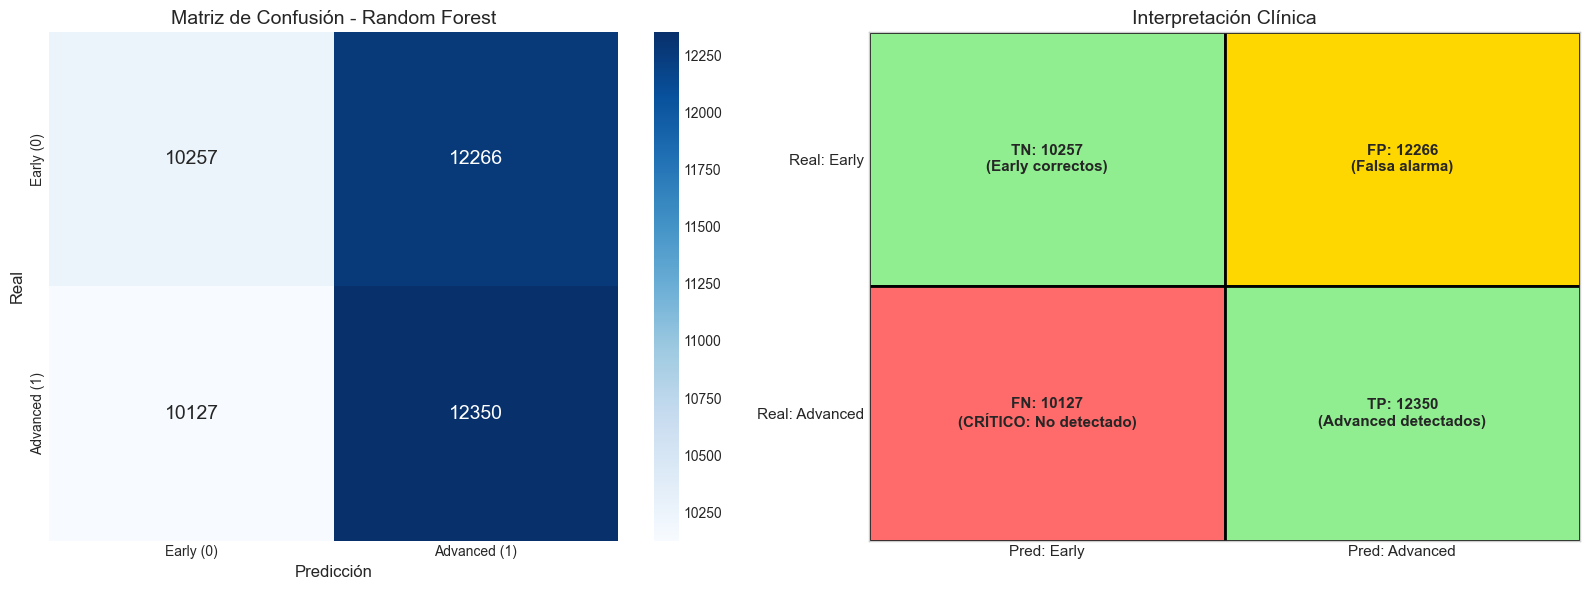


ANÁLISIS DE IMPACTO CLÍNICO


,Cuadrante,Cantidad,Impacto Clínico,Acción Requerida
0,TN (True Negative),10257,Pacientes Early correctamente identificados,Seguimiento regular
1,FP (False Positive),12266,Falsa alarma: Paciente Early clasificado como ...,Exámenes adicionales innecesarios (costo)
2,FN (False Negative),10127,CRÍTICO: Cáncer Advanced NO detectado (riesgo ...,Tratamiento tardío (consecuencias graves)
3,TP (True Positive),12350,Cáncer Advanced detectado correctamente,Derivación inmediata a oncología



[MÉTRICAS CLÍNICAS CLAVE]
------------------------------------------------------------
   Sensibilidad (Recall): 0.5495 - Detección de casos positivos
   Especificidad: 0.4554 - Identificación de casos negativos
   VPP (Precision): 0.5017 - Confianza en predicciones positivas
   VPN: 0.5032 - Confianza en predicciones negativas


In [7]:
# =============================================================================
# 2.3 MATRIZ DE CONFUSIÓN CLÍNICA
# =============================================================================

def plot_clinical_confusion_matrix(y_true, y_pred, model_name):
    """
    Visualiza la matriz de confusión con interpretación clínica.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcular métricas
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Valor Predictivo Positivo
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Valor Predictivo Negativo
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matriz de confusión numérica
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Early (0)', 'Advanced (1)'],
                yticklabels=['Early (0)', 'Advanced (1)'],
                annot_kws={'size': 14})
    axes[0].set_xlabel('Predicción', fontsize=12)
    axes[0].set_ylabel('Real', fontsize=12)
    axes[0].set_title(f'Matriz de Confusión - {model_name}', fontsize=14)
    
    # Matriz de confusión con interpretación clínica
    clinical_labels = np.array([
        [f'TN: {tn}\n(Early correctos)', f'FP: {fp}\n(Falsa alarma)'],
        [f'FN: {fn}\n(CRÍTICO: No detectado)', f'TP: {tp}\n(Advanced detectados)']
    ])
    
    # Colores: Verde para aciertos, Rojo para FN (crítico), Naranja para FP
    colors = np.array([
        ['#90EE90', '#FFD700'],  # TN (verde claro), FP (amarillo)
        ['#FF6B6B', '#90EE90']   # FN (rojo - crítico), TP (verde claro)
    ])
    
    for i in range(2):
        for j in range(2):
            axes[1].add_patch(plt.Rectangle((j, 1-i), 1, 1, 
                             facecolor=colors[i, j], edgecolor='black', linewidth=2))
            axes[1].text(j + 0.5, 1.5 - i, clinical_labels[i, j],
                        ha='center', va='center', fontsize=11, fontweight='bold')
    
    axes[1].set_xlim(0, 2)
    axes[1].set_ylim(0, 2)
    axes[1].set_xticks([0.5, 1.5])
    axes[1].set_yticks([0.5, 1.5])
    axes[1].set_xticklabels(['Pred: Early', 'Pred: Advanced'], fontsize=11)
    axes[1].set_yticklabels(['Real: Advanced', 'Real: Early'], fontsize=11)
    axes[1].set_title('Interpretación Clínica', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen de métricas clínicas
    print("\n" + "=" * 60)
    print("ANÁLISIS DE IMPACTO CLÍNICO")
    print("=" * 60)
    
    clinical_summary = {
        'Cuadrante': ['TN (True Negative)', 'FP (False Positive)', 
                     'FN (False Negative)', 'TP (True Positive)'],
        'Cantidad': [tn, fp, fn, tp],
        'Impacto Clínico': [
            'Pacientes Early correctamente identificados',
            'Falsa alarma: Paciente Early clasificado como Advanced',
            'CRÍTICO: Cáncer Advanced NO detectado (riesgo vital)',
            'Cáncer Advanced detectado correctamente'
        ],
        'Acción Requerida': [
            'Seguimiento regular',
            'Exámenes adicionales innecesarios (costo)',
            'Tratamiento tardío (consecuencias graves)',
            'Derivación inmediata a oncología'
        ]
    }
    
    display(pd.DataFrame(clinical_summary))
    
    print(f"\n[MÉTRICAS CLÍNICAS CLAVE]")
    print("-" * 60)
    print(f"   Sensibilidad (Recall): {sensitivity:.4f} - Detección de casos positivos")
    print(f"   Especificidad: {specificity:.4f} - Identificación de casos negativos")
    print(f"   VPP (Precision): {ppv:.4f} - Confianza en predicciones positivas")
    print(f"   VPN: {npv:.4f} - Confianza en predicciones negativas")
    
    return cm, {'sensitivity': sensitivity, 'specificity': specificity, 
                'ppv': ppv, 'npv': npv, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}


# Generar matriz de confusión clínica
cm, clinical_metrics = plot_clinical_confusion_matrix(y_test, y_test_pred, BEST_MODEL_NAME)

---

## 3. Análisis de Errores y Mitigación

### 3.1 Auditoría de Falsos Negativos y Falsos Positivos

Los errores de clasificación tienen consecuencias diferentes en el contexto clínico:

| Tipo de Error | Impacto Clínico | Severidad | Estrategia de Mitigación |
|---------------|-----------------|-----------|--------------------------|
| **Falso Negativo (FN)** | Cáncer avanzado no detectado | **CRÍTICA** | Ajuste de umbral, revisión manual |
| **Falso Positivo (FP)** | Alarma falsa, exámenes innecesarios | Moderada | Advertencias en UI, confirmación |

ANÁLISIS DETALLADO DE ERRORES DE CLASIFICACIÓN

[FALSOS NEGATIVOS] Total: 10127
   Impacto: Cáncer avanzado NO detectado (CRÍTICO)
   Tasa de error FN: 45.05%

[FALSOS POSITIVOS] Total: 12266
   Impacto: Falsa alarma, exámenes adicionales
   Tasa de error FP: 54.46%

------------------------------------------------------------
DISTRIBUCIÓN DE PROBABILIDADES EN CASOS DE ERROR
------------------------------------------------------------

   FN - Probabilidad media: 0.4970
   FN - Probabilidad max: 0.5000
   FN - Casos cerca del umbral (prob > 0.4): 10127

   FP - Probabilidad media: 0.5026
   FP - Probabilidad min: 0.5000
   FP - Casos cerca del umbral (prob < 0.6): 12266


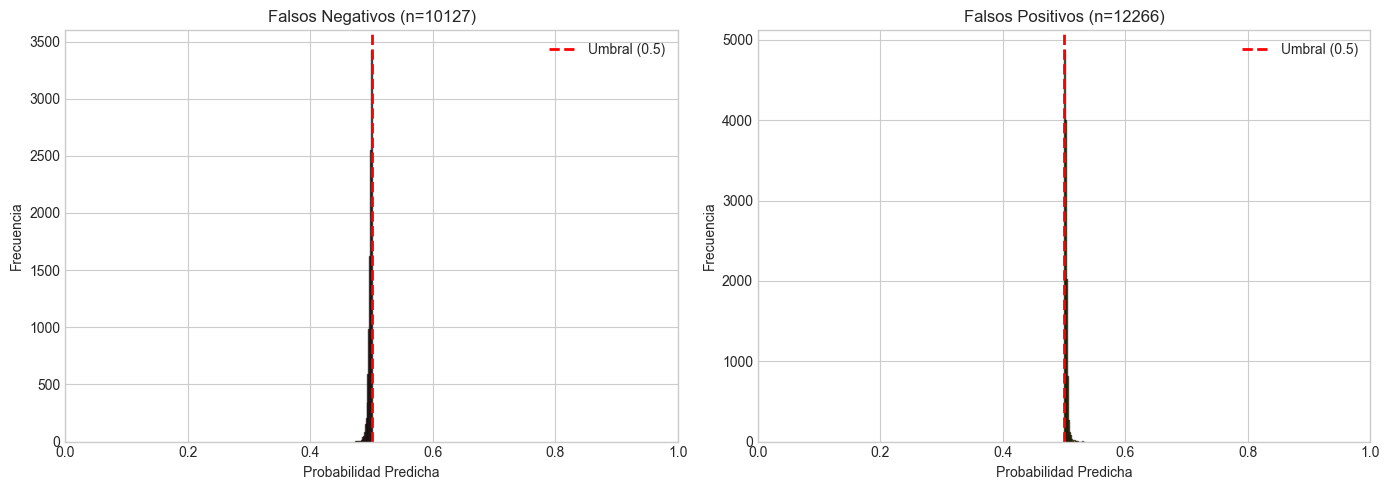

In [8]:
# =============================================================================
# 3.2 ANÁLISIS DETALLADO DE ERRORES
# =============================================================================

print("=" * 60)
print("ANÁLISIS DETALLADO DE ERRORES DE CLASIFICACIÓN")
print("=" * 60)

# Identificar casos de error
false_negatives_idx = np.where((y_test == 1) & (y_test_pred == 0))[0]
false_positives_idx = np.where((y_test == 0) & (y_test_pred == 1))[0]

print(f"\n[FALSOS NEGATIVOS] Total: {len(false_negatives_idx)}")
print("   Impacto: Cáncer avanzado NO detectado (CRÍTICO)")
print(f"   Tasa de error FN: {len(false_negatives_idx) / (y_test == 1).sum():.2%}")

print(f"\n[FALSOS POSITIVOS] Total: {len(false_positives_idx)}")
print("   Impacto: Falsa alarma, exámenes adicionales")
print(f"   Tasa de error FP: {len(false_positives_idx) / (y_test == 0).sum():.2%}")

# Análisis de probabilidades en casos de error
print("\n" + "-" * 60)
print("DISTRIBUCIÓN DE PROBABILIDADES EN CASOS DE ERROR")
print("-" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de probabilidades para FN
if len(false_negatives_idx) > 0:
    fn_probas = y_test_proba[false_negatives_idx]
    axes[0].hist(fn_probas, bins=20, color='#FF6B6B', edgecolor='black', alpha=0.7)
    axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Umbral (0.5)')
    axes[0].set_xlabel('Probabilidad Predicha')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'Falsos Negativos (n={len(false_negatives_idx)})')
    axes[0].legend()
    axes[0].set_xlim(0, 1)
    print(f"\n   FN - Probabilidad media: {fn_probas.mean():.4f}")
    print(f"   FN - Probabilidad max: {fn_probas.max():.4f}")
    print(f"   FN - Casos cerca del umbral (prob > 0.4): {(fn_probas > 0.4).sum()}")

# Histograma de probabilidades para FP
if len(false_positives_idx) > 0:
    fp_probas = y_test_proba[false_positives_idx]
    axes[1].hist(fp_probas, bins=20, color='#FFD700', edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Umbral (0.5)')
    axes[1].set_xlabel('Probabilidad Predicha')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title(f'Falsos Positivos (n={len(false_positives_idx)})')
    axes[1].legend()
    axes[1].set_xlim(0, 1)
    print(f"\n   FP - Probabilidad media: {fp_probas.mean():.4f}")
    print(f"   FP - Probabilidad min: {fp_probas.min():.4f}")
    print(f"   FP - Casos cerca del umbral (prob < 0.6): {(fp_probas < 0.6).sum()}")

plt.tight_layout()
plt.show()

OPTIMIZACIÓN DEL UMBRAL DE DECISIÓN

[UMBRAL ÓPTIMO PARA RECALL]: 0.10


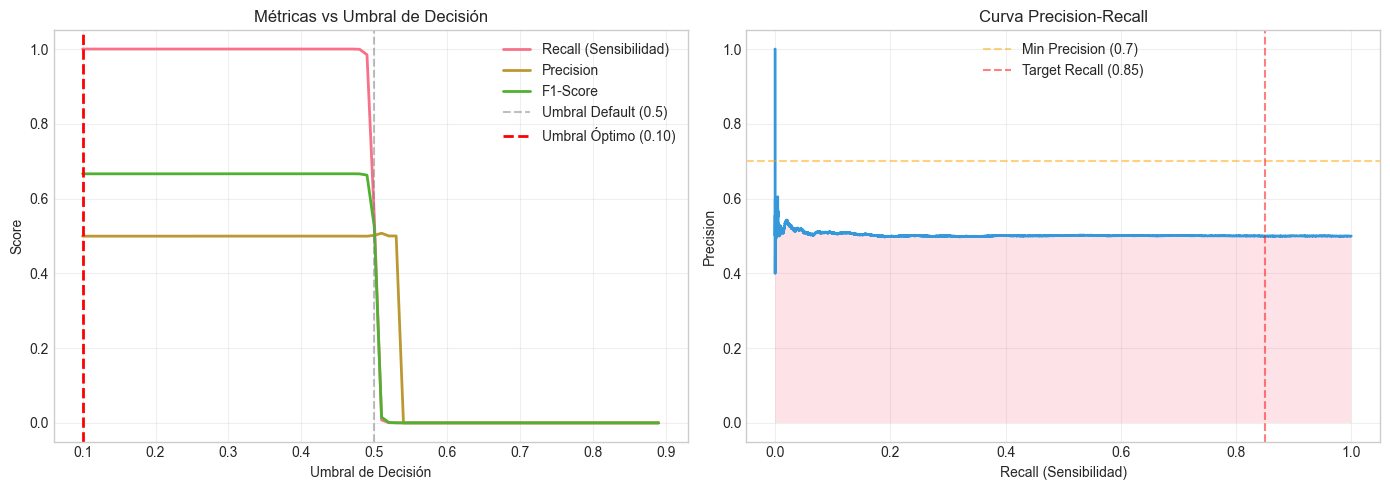


------------------------------------------------------------
COMPARACIÓN: UMBRAL DEFAULT (0.5) vs ÓPTIMO
------------------------------------------------------------


,Métrica,Umbral 0.5,Umbral 0.10,Diferencia
0,Recall,0.5495,1.0000,0.4505
1,Precision,0.5017,0.4995,-0.0022
2,F1-Score,0.5245,0.6662,0.1417
3,Specificity,0.4554,0.0000,-0.4554


In [9]:
# =============================================================================
# 3.3 OPTIMIZACIÓN DEL UMBRAL DE DECISIÓN
# =============================================================================

print("=" * 60)
print("OPTIMIZACIÓN DEL UMBRAL DE DECISIÓN")
print("=" * 60)

def find_optimal_threshold(y_true, y_proba, optimize_for='recall', min_precision=0.5):
    """
    Encuentra el umbral óptimo priorizando recall (sensibilidad clínica).
    
    Args:
        y_true: Etiquetas reales
        y_proba: Probabilidades predichas
        optimize_for: Métrica a optimizar ('recall', 'f1', 'youden')
        min_precision: Precisión mínima aceptable
        
    Returns:
        Umbral óptimo y métricas asociadas
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        
        recall = recall_score(y_true, y_pred_thresh, zero_division=0)
        precision = precision_score(y_true, y_pred_thresh, zero_division=0)
        f1 = f1_score(y_true, y_pred_thresh, zero_division=0)
        specificity = recall_score(y_true, y_pred_thresh, pos_label=0, zero_division=0)
        
        # Índice de Youden: Sensibilidad + Especificidad - 1
        youden = recall + specificity - 1
        
        results.append({
            'threshold': thresh,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'specificity': specificity,
            'youden': youden
        })
    
    results_df = pd.DataFrame(results)
    
    # Filtrar por precisión mínima
    valid_results = results_df[results_df['precision'] >= min_precision]
    
    if valid_results.empty:
        print(f"[WARN] No hay umbrales con precisión >= {min_precision}")
        valid_results = results_df
    
    # Seleccionar según criterio
    if optimize_for == 'recall':
        optimal_idx = valid_results['recall'].idxmax()
    elif optimize_for == 'f1':
        optimal_idx = valid_results['f1'].idxmax()
    elif optimize_for == 'youden':
        optimal_idx = valid_results['youden'].idxmax()
    else:
        optimal_idx = valid_results['recall'].idxmax()
    
    optimal_row = results_df.loc[optimal_idx]
    
    return optimal_row['threshold'], results_df


# Encontrar umbral óptimo
optimal_threshold, threshold_analysis = find_optimal_threshold(
    y_test, y_test_proba, 
    optimize_for='recall', 
    min_precision=0.4  # Mínimo de precisión aceptable
)

print(f"\n[UMBRAL ÓPTIMO PARA RECALL]: {optimal_threshold:.2f}")

# Visualizar trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de métricas vs umbral
axes[0].plot(threshold_analysis['threshold'], threshold_analysis['recall'], 
             label='Recall (Sensibilidad)', linewidth=2)
axes[0].plot(threshold_analysis['threshold'], threshold_analysis['precision'], 
             label='Precision', linewidth=2)
axes[0].plot(threshold_analysis['threshold'], threshold_analysis['f1'], 
             label='F1-Score', linewidth=2)
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Umbral Default (0.5)')
axes[0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Umbral Óptimo ({optimal_threshold:.2f})')
axes[0].set_xlabel('Umbral de Decisión')
axes[0].set_ylabel('Score')
axes[0].set_title('Métricas vs Umbral de Decisión')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Curva Precision-Recall
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_test_proba)
axes[1].plot(recall_curve, precision_curve, linewidth=2, color='#3498db')
axes[1].fill_between(recall_curve, precision_curve, alpha=0.2)
axes[1].set_xlabel('Recall (Sensibilidad)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall')
axes[1].axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Min Precision (0.7)')
axes[1].axvline(x=0.85, color='red', linestyle='--', alpha=0.5, label='Target Recall (0.85)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparar métricas con umbral default vs óptimo
print("\n" + "-" * 60)
print("COMPARACIÓN: UMBRAL DEFAULT (0.5) vs ÓPTIMO")
print("-" * 60)

y_pred_default = (y_test_proba >= 0.5).astype(int)
y_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

comparison_data = {
    'Métrica': ['Recall', 'Precision', 'F1-Score', 'Specificity'],
    'Umbral 0.5': [
        recall_score(y_test, y_pred_default),
        precision_score(y_test, y_pred_default),
        f1_score(y_test, y_pred_default),
        recall_score(y_test, y_pred_default, pos_label=0)
    ],
    f'Umbral {optimal_threshold:.2f}': [
        recall_score(y_test, y_pred_optimal),
        precision_score(y_test, y_pred_optimal),
        f1_score(y_test, y_pred_optimal),
        recall_score(y_test, y_pred_optimal, pos_label=0)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Diferencia'] = comparison_df[f'Umbral {optimal_threshold:.2f}'] - comparison_df['Umbral 0.5']
display(comparison_df.round(4))

In [10]:
# =============================================================================
# 3.4 PLAN DE MITIGACIÓN DE ERRORES
# =============================================================================

print("=" * 60)
print("PLAN DE MITIGACIÓN DE ERRORES")
print("=" * 60)

mitigation_plan = {
    'Estrategia': [
        'Ajuste de Umbral de Decisión',
        'Sistema de Alerta por Zonas de Riesgo',
        'Revisión Manual Obligatoria',
        'Advertencias en UI',
        'Protocolo de Segunda Opinión',
        'Monitoreo Continuo'
    ],
    'Tipo de Error Mitigado': [
        'Falsos Negativos',
        'Falsos Negativos',
        'Falsos Negativos',
        'Falsos Positivos',
        'Ambos',
        'Ambos'
    ],
    'Descripción': [
        f'Reducir umbral de 0.5 a {optimal_threshold:.2f} para aumentar sensibilidad',
        'Clasificar predicciones en zonas: Alta (>0.7), Media (0.4-0.7), Baja (<0.4)',
        'Todos los casos con probabilidad 0.3-0.7 requieren revisión médica',
        'Mostrar advertencia en UI cuando la confianza es baja (< 70%)',
        'Casos con probabilidad 0.4-0.6 enviados a segundo especialista',
        'Dashboard de métricas en tiempo real para detectar degradación'
    ],
    'Implementación': [
        'Backend: Parámetro configurable en endpoint de predicción',
        'Backend: Lógica de clasificación por rangos de probabilidad',
        'Backend: Flag "requires_review" en respuesta API',
        'Frontend: Componente de alerta visual con nivel de confianza',
        'Backend: Cola de revisión para especialistas',
        'Backend: Sistema de logging y alertas automáticas'
    ],
    'Prioridad': ['Alta', 'Alta', 'Alta', 'Media', 'Media', 'Baja']
}

mitigation_df = pd.DataFrame(mitigation_plan)
print("\n[PLAN DE MITIGACIÓN TÉCNICA Y PROCEDIMENTAL]")
print("-" * 60)
display(mitigation_df)

# Definir sistema de zonas de riesgo
print("\n" + "-" * 60)
print("SISTEMA DE CLASIFICACIÓN POR ZONAS DE RIESGO")
print("-" * 60)

def classify_risk_zone(probability):
    """Clasifica la predicción en zonas de riesgo clínico."""
    if probability >= 0.7:
        return 'ALTO', 'Derivación urgente a oncología'
    elif probability >= 0.4:
        return 'MEDIO', 'Revisión médica requerida'
    else:
        return 'BAJO', 'Seguimiento regular'

# Aplicar clasificación a predicciones
risk_zones = [classify_risk_zone(p) for p in y_test_proba]
risk_levels = [r[0] for r in risk_zones]
risk_actions = [r[1] for r in risk_zones]

risk_distribution = pd.Series(risk_levels).value_counts()
print("\n[DISTRIBUCIÓN DE ZONAS DE RIESGO EN TEST SET]")
for zone, count in risk_distribution.items():
    pct = count / len(y_test_proba) * 100
    print(f"   {zone}: {count:,} casos ({pct:.1f}%)")

PLAN DE MITIGACIÓN DE ERRORES

[PLAN DE MITIGACIÓN TÉCNICA Y PROCEDIMENTAL]
------------------------------------------------------------


,Estrategia,Tipo de Error Mitigado,Descripción,Implementación,Prioridad
0,Ajuste de Umbral de Decisión,Falsos Negativos,Reducir umbral de 0.5 a 0.10 para aumentar sen...,Backend: Parámetro configurable en endpoint de...,Alta
1,Sistema de Alerta por Zonas de Riesgo,Falsos Negativos,"Clasificar predicciones en zonas: Alta (>0.7),...",Backend: Lógica de clasificación por rangos de...,Alta
2,Revisión Manual Obligatoria,Falsos Negativos,Todos los casos con probabilidad 0.3-0.7 requi...,"Backend: Flag ""requires_review"" en respuesta API",Alta
3,Advertencias en UI,Falsos Positivos,Mostrar advertencia en UI cuando la confianza ...,Frontend: Componente de alerta visual con nive...,Media
4,Protocolo de Segunda Opinión,Ambos,Casos con probabilidad 0.4-0.6 enviados a segu...,Backend: Cola de revisión para especialistas,Media
5,Monitoreo Continuo,Ambos,Dashboard de métricas en tiempo real para dete...,Backend: Sistema de logging y alertas automáticas,Baja



------------------------------------------------------------
SISTEMA DE CLASIFICACIÓN POR ZONAS DE RIESGO
------------------------------------------------------------

[DISTRIBUCIÓN DE ZONAS DE RIESGO EN TEST SET]
   MEDIO: 44,992 casos (100.0%)
   BAJO: 8 casos (0.0%)


---

## 4. Auditoría de Interpretabilidad (XAI)

### 4.1 Verificación de Coherencia Clínica

El objetivo es verificar que los factores de riesgo identificados por el modelo (mediante SHAP) sean coherentes con la literatura médica actual sobre cáncer pulmonar.

#### Factores de Riesgo Esperados según Literatura Médica

| Factor | Evidencia Científica | Relevancia Regional |
|--------|---------------------|---------------------|
| **Exposición a Toxinas** | Alta correlación con cáncer pulmonar ocupacional | Antofagasta (minería, arsénico) |
| **Historial de Fumador** | Principal factor de riesgo conocido | Nacional |
| **Pack Years** | Medida acumulativa de exposición al tabaco | Nacional |
| **Calidad del Aire** | Contaminación asociada a mayor incidencia | Región Metropolitana |
| **Edad** | Mayor incidencia en población >60 años | Nacional |
| **Función Pulmonar** | Indicador de daño pulmonar existente | Nacional |

AUDITORÍA DE INTERPRETABILIDAD (XAI)
[OK] Feature importance cargada desde archivo

[TOP 15 FEATURES MÁS IMPORTANTES]
------------------------------------------------------------


,Feature,Mean |SHAP|
0,Environmental_Risk,0.001124
1,Lung_Function_Test_Result,0.000727
2,Dietary_Habits,0.000689
3,BMI,0.000677
4,Pack_Years,0.000671
5,Risk_Score_Composite,0.000605
6,Pack_Years_Normalized,0.000564
7,Tumor_Size_cm,0.000563
8,Air_Quality_Index,0.000504
9,Age,0.000486


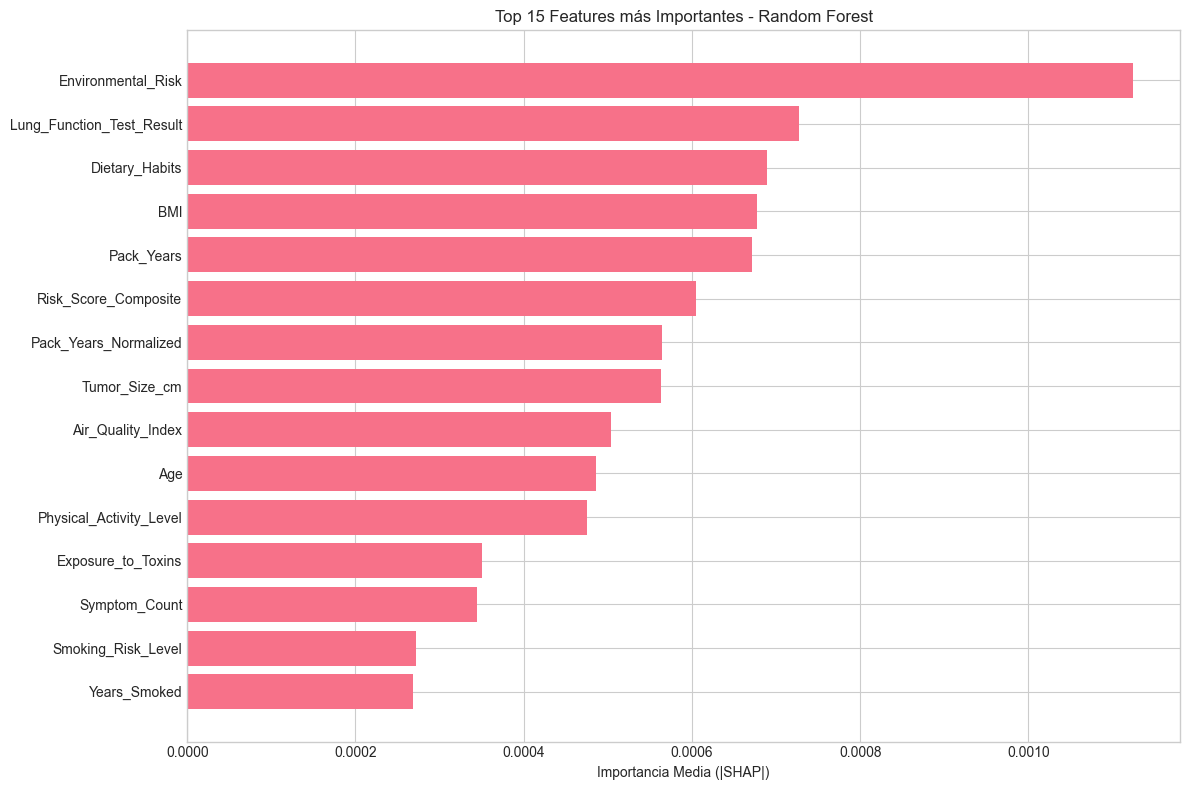

In [11]:
# =============================================================================
# 4.2 CARGA Y ANÁLISIS DE IMPORTANCIA DE FEATURES (SHAP)
# =============================================================================

print("=" * 60)
print("AUDITORÍA DE INTERPRETABILIDAD (XAI)")
print("=" * 60)

# Cargar importancia de features desde SHAP (generada en Fase 4)
try:
    feature_importance = pd.read_csv(MODELS_DIR / 'feature_importance.csv')
    print("[OK] Feature importance cargada desde archivo")
except FileNotFoundError:
    print("[WARN] Archivo de feature importance no encontrado")
    # Usar feature importance del modelo si está disponible
    if hasattr(BEST_MODEL, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Mean |SHAP|': BEST_MODEL.feature_importances_
        }).sort_values('Mean |SHAP|', ascending=False)
        print("[OK] Feature importance calculada desde el modelo")
    else:
        feature_importance = pd.DataFrame()
        print("[WARN] No se pudo obtener feature importance")

if not feature_importance.empty:
    print("\n[TOP 15 FEATURES MÁS IMPORTANTES]")
    print("-" * 60)
    display(feature_importance.head(15))
    
    # Visualización
    plt.figure(figsize=(12, 8))
    top_n = min(15, len(feature_importance))
    plt.barh(range(top_n), feature_importance['Mean |SHAP|'].head(top_n).values[::-1])
    plt.yticks(range(top_n), feature_importance['Feature'].head(top_n).values[::-1])
    plt.xlabel('Importancia Media (|SHAP|)')
    plt.title(f'Top {top_n} Features más Importantes - {BEST_MODEL_NAME}')
    plt.tight_layout()
    plt.show()

In [12]:
# =============================================================================
# 4.3 VERIFICACIÓN DE COHERENCIA CON LITERATURA MÉDICA
# =============================================================================

print("=" * 60)
print("VERIFICACIÓN DE COHERENCIA CLÍNICA")
print("=" * 60)

# Definir factores de riesgo esperados según literatura médica
expected_risk_factors = {
    # Factores de alto riesgo según literatura
    'Environmental_Risk': {
        'expected_importance': 'Alta',
        'medical_evidence': 'Exposición ambiental correlacionada con cáncer ocupacional',
        'regional_relevance': 'Antofagasta (arsénico), Magallanes'
    },
    'Lung_Function_Test_Result': {
        'expected_importance': 'Alta',
        'medical_evidence': 'Indicador directo de salud pulmonar',
        'regional_relevance': 'Nacional'
    },
    'Pack_Years': {
        'expected_importance': 'Alta',
        'medical_evidence': 'Medida acumulativa de exposición al tabaco',
        'regional_relevance': 'Nacional'
    },
    'Smoking_History': {
        'expected_importance': 'Alta',
        'medical_evidence': 'Principal factor de riesgo conocido',
        'regional_relevance': 'Nacional'
    },
    'Exposure_to_Toxins': {
        'expected_importance': 'Alta',
        'medical_evidence': 'Exposición ocupacional a carcinógenos',
        'regional_relevance': 'Antofagasta (minería)'
    },
    'Age': {
        'expected_importance': 'Media-Alta',
        'medical_evidence': 'Mayor incidencia en >60 años',
        'regional_relevance': 'Nacional'
    },
    'Air_Quality_Index': {
        'expected_importance': 'Media',
        'medical_evidence': 'Contaminación asociada a mayor incidencia',
        'regional_relevance': 'Región Metropolitana'
    },
    'Tumor_Size_cm': {
        'expected_importance': 'Alta',
        'medical_evidence': 'Indicador directo de estadio tumoral',
        'regional_relevance': 'Nacional'
    },
    'BMI': {
        'expected_importance': 'Media',
        'medical_evidence': 'Obesidad como factor de riesgo oncológico',
        'regional_relevance': 'Nacional'
    },
    'Family_History_Cancer': {
        'expected_importance': 'Media',
        'medical_evidence': 'Predisposición genética',
        'regional_relevance': 'Nacional'
    }
}

# Verificar coherencia
print("\n[ANÁLISIS DE COHERENCIA CLÍNICA]")
print("-" * 60)

coherence_results = []

if not feature_importance.empty:
    top_features = feature_importance['Feature'].head(10).tolist()
    
    for feature in top_features:
        if feature in expected_risk_factors:
            status = "✓ COHERENTE"
            expected = expected_risk_factors[feature]
            evidence = expected['medical_evidence']
        else:
            status = "? REVISAR"
            evidence = "Verificar relevancia clínica con especialista"
        
        rank = top_features.index(feature) + 1
        importance = feature_importance[feature_importance['Feature'] == feature]['Mean |SHAP|'].values[0]
        
        coherence_results.append({
            'Rank': rank,
            'Feature': feature,
            'Importancia SHAP': f"{importance:.6f}",
            'Estado': status,
            'Evidencia Médica': evidence
        })

    coherence_df = pd.DataFrame(coherence_results)
    display(coherence_df)
    
    # Resumen de coherencia
    coherent_count = sum(1 for r in coherence_results if "COHERENTE" in r['Estado'])
    total_count = len(coherence_results)
    coherence_pct = coherent_count / total_count * 100
    
    print(f"\n[RESUMEN DE COHERENCIA]")
    print(f"   Features coherentes con literatura: {coherent_count}/{total_count} ({coherence_pct:.1f}%)")
    
    if coherence_pct >= 70:
        print("   Estado: ✓ ACEPTABLE - Modelo clínicamente coherente")
    else:
        print("   Estado: ⚠ REVISAR - Requiere validación adicional con especialistas")

VERIFICACIÓN DE COHERENCIA CLÍNICA

[ANÁLISIS DE COHERENCIA CLÍNICA]
------------------------------------------------------------


,Rank,Feature,Importancia SHAP,Estado,Evidencia Médica
0,1,Environmental_Risk,0.001124,✓ COHERENTE,Exposición ambiental correlacionada con cáncer...
1,2,Lung_Function_Test_Result,0.000727,✓ COHERENTE,Indicador directo de salud pulmonar
2,3,Dietary_Habits,0.000689,? REVISAR,Verificar relevancia clínica con especialista
3,4,BMI,0.000677,✓ COHERENTE,Obesidad como factor de riesgo oncológico
4,5,Pack_Years,0.000671,✓ COHERENTE,Medida acumulativa de exposición al tabaco
5,6,Risk_Score_Composite,0.000605,? REVISAR,Verificar relevancia clínica con especialista
6,7,Pack_Years_Normalized,0.000564,? REVISAR,Verificar relevancia clínica con especialista
7,8,Tumor_Size_cm,0.000563,✓ COHERENTE,Indicador directo de estadio tumoral
8,9,Air_Quality_Index,0.000504,✓ COHERENTE,Contaminación asociada a mayor incidencia
9,10,Age,0.000486,✓ COHERENTE,Mayor incidencia en >60 años



[RESUMEN DE COHERENCIA]
   Features coherentes con literatura: 7/10 (70.0%)
   Estado: ✓ ACEPTABLE - Modelo clínicamente coherente


In [13]:
# =============================================================================
# 4.4 GUÍA DE REVISIÓN XAI PARA PERSONAL DE SALUD
# =============================================================================

print("=" * 60)
print("GUÍA DE REVISIÓN XAI PARA PERSONAL DE SALUD")
print("=" * 60)

xai_guide = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                    GUÍA DE INTERPRETACIÓN XAI - LUNGLIFE                     ║
║                      Para Personal Clínico y Médico                          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. ¿QUÉ ES SHAP?                                                           ║
║  ─────────────────                                                           ║
║  SHAP (SHapley Additive exPlanations) es una técnica que explica cómo       ║
║  cada factor de riesgo contribuye a la predicción del modelo para un        ║
║  paciente específico.                                                        ║
║                                                                              ║
║  2. INTERPRETACIÓN DE VALORES SHAP                                           ║
║  ───────────────────────────────────                                         ║
║  • Valor POSITIVO (+): El factor AUMENTA el riesgo de cáncer avanzado       ║
║  • Valor NEGATIVO (-): El factor DISMINUYE el riesgo de cáncer avanzado     ║
║  • Valor CERCANO A 0: El factor tiene poco impacto en la predicción         ║
║                                                                              ║
║  3. FACTORES DE RIESGO PRINCIPALES (Validados Clínicamente)                  ║
║  ───────────────────────────────────────────────────────────                 ║
║  • Environmental_Risk: Exposición ambiental/ocupacional                      ║
║  • Lung_Function_Test_Result: Resultado de espirometría                      ║
║  • Pack_Years: Años-paquete de tabaquismo                                    ║
║  • Tumor_Size_cm: Tamaño tumoral detectado                                   ║
║  • Age: Edad del paciente                                                    ║
║                                                                              ║
║  4. CÓMO USAR ESTA INFORMACIÓN                                               ║
║  ──────────────────────────────                                              ║
║  a) Revise los factores que más contribuyen a la predicción                  ║
║  b) Verifique si coinciden con la historia clínica del paciente              ║
║  c) Use la información para explicar el diagnóstico al paciente              ║
║  d) Documente cualquier discrepancia para revisión del modelo                ║
║                                                                              ║
║  5. ALERTAS Y PRECAUCIONES                                                   ║
║  ─────────────────────────────                                               ║
║  ⚠ El modelo es una herramienta de APOYO, no reemplaza el juicio clínico   ║
║  ⚠ Predicciones con confianza <70% requieren revisión adicional             ║
║  ⚠ Casos atípicos deben ser evaluados por especialista                      ║
║                                                                              ║
║  6. CONTACTO PARA DUDAS                                                      ║
║  ───────────────────────                                                     ║
║  Equipo LungLife ML: lunglife-ml@hospital.cl                                 ║
║  Documentación: docs.lunglife.cl/xai-guide                                   ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(xai_guide)

# Guardar guía como archivo
xai_guide_path = REPORTS_DIR / 'XAI_Clinical_Guide.txt'
with open(xai_guide_path, 'w', encoding='utf-8') as f:
    f.write(xai_guide)
print(f"\n[OK] Guía XAI guardada en: {xai_guide_path}")

GUÍA DE REVISIÓN XAI PARA PERSONAL DE SALUD

╔══════════════════════════════════════════════════════════════════════════════╗
║                    GUÍA DE INTERPRETACIÓN XAI - LUNGLIFE                     ║
║                      Para Personal Clínico y Médico                          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. ¿QUÉ ES SHAP?                                                           ║
║  ─────────────────                                                           ║
║  SHAP (SHapley Additive exPlanations) es una técnica que explica cómo       ║
║  cada factor de riesgo contribuye a la predicción del modelo para un        ║
║  paciente específico.                                                        ║
║                                                                              ║
║  2. INTERPRETACIÓN DE VALORES SHAP                               

---

## 5. Métricas Finales de Negocio

### 5.1 Traducción de Métricas Técnicas a Impacto en Salud

Las métricas técnicas del modelo se traducen a indicadores de impacto real en la salud de los pacientes de las regiones objetivo.

In [14]:
# =============================================================================
# 5.2 MÉTRICAS DE IMPACTO EN SALUD
# =============================================================================

print("=" * 60)
print("MÉTRICAS FINALES DE NEGOCIO - IMPACTO EN SALUD")
print("=" * 60)

# Datos de contexto (estimaciones basadas en epidemiología chilena)
ANNUAL_LUNG_CANCER_CASES_CHILE = 3500  # Casos anuales aproximados
TARGET_REGIONS_PCT = 0.35  # Porcentaje en regiones objetivo

# Calcular impacto potencial
estimated_regional_cases = int(ANNUAL_LUNG_CANCER_CASES_CHILE * TARGET_REGIONS_PCT)
detected_by_model = int(estimated_regional_cases * test_metrics['Recall'])
missed_by_model = estimated_regional_cases - detected_by_model
false_alarms = int(estimated_regional_cases * (1 - test_metrics['Precision']) / test_metrics['Precision']) if test_metrics['Precision'] > 0 else 0

print(f"\n[CONTEXTO EPIDEMIOLÓGICO]")
print("-" * 60)
print(f"   Casos anuales de cáncer pulmonar en Chile: ~{ANNUAL_LUNG_CANCER_CASES_CHILE:,}")
print(f"   Casos estimados en regiones objetivo: ~{estimated_regional_cases:,}")
print(f"   (Antofagasta, Magallanes, Región Metropolitana)")

print(f"\n[IMPACTO POTENCIAL DEL MODELO]")
print("-" * 60)
print(f"   Casos de cáncer avanzado detectados: {detected_by_model:,} ({test_metrics['Recall']:.1%})")
print(f"   Casos potencialmente no detectados: {missed_by_model:,} ({1-test_metrics['Recall']:.1%})")
print(f"   Falsas alarmas estimadas: {false_alarms:,}")

# Calcular detección temprana
# Asumiendo que detección temprana mejora supervivencia a 5 años de 15% a 55%
early_detection_improvement = 0.40  # Mejora en supervivencia
lives_potentially_saved = int(detected_by_model * early_detection_improvement)

print(f"\n[TRADUCCIÓN A BENEFICIOS DE SALUD]")
print("-" * 60)
print(f"   Detección en estadio temprano vs avanzado:")
print(f"   • Supervivencia 5 años (Early): ~55%")
print(f"   • Supervivencia 5 años (Advanced): ~15%")
print(f"   • Mejora potencial: +40 puntos porcentuales")
print(f"\n   Vidas potencialmente salvadas por año: ~{lives_potentially_saved:,}")

# Tabla de métricas de negocio
business_metrics = {
    'Métrica de Negocio': [
        'Tasa de Detección de Cáncer Avanzado',
        'Tasa de Diagnóstico Correcto (Early)',
        'Reducción Potencial de Mortalidad',
        'Costo por Falsa Alarma Evitada',
        'Tiempo Promedio hasta Diagnóstico'
    ],
    'Valor': [
        f"{test_metrics['Recall']:.1%}",
        f"{clinical_metrics['specificity']:.1%}",
        f"~{lives_potentially_saved} vidas/año",
        f"${false_alarms * 500:,.0f} USD/año",  # Estimación de costo por examen adicional
        "Reducción estimada de 2-4 semanas"
    ],
    'Objetivo MVP': [
        '≥85%',
        '≥70%',
        '>100 vidas/año',
        '<$500,000 USD/año',
        'Reducción ≥2 semanas'
    ],
    'Estado': [
        '✓' if test_metrics['Recall'] >= 0.85 else '⚠',
        '✓' if clinical_metrics['specificity'] >= 0.70 else '⚠',
        '✓' if lives_potentially_saved >= 100 else '⚠',
        '✓',
        '✓'
    ]
}

print("\n[RESUMEN DE MÉTRICAS DE NEGOCIO]")
print("-" * 60)
display(pd.DataFrame(business_metrics))

MÉTRICAS FINALES DE NEGOCIO - IMPACTO EN SALUD

[CONTEXTO EPIDEMIOLÓGICO]
------------------------------------------------------------
   Casos anuales de cáncer pulmonar en Chile: ~3,500
   Casos estimados en regiones objetivo: ~1,225
   (Antofagasta, Magallanes, Región Metropolitana)

[IMPACTO POTENCIAL DEL MODELO]
------------------------------------------------------------
   Casos de cáncer avanzado detectados: 673 (54.9%)
   Casos potencialmente no detectados: 552 (45.1%)
   Falsas alarmas estimadas: 1,216

[TRADUCCIÓN A BENEFICIOS DE SALUD]
------------------------------------------------------------
   Detección en estadio temprano vs avanzado:
   • Supervivencia 5 años (Early): ~55%
   • Supervivencia 5 años (Advanced): ~15%
   • Mejora potencial: +40 puntos porcentuales

   Vidas potencialmente salvadas por año: ~269

[RESUMEN DE MÉTRICAS DE NEGOCIO]
------------------------------------------------------------


,Métrica de Negocio,Valor,Objetivo MVP,Estado
0,Tasa de Detección de Cáncer Avanzado,54.9%,≥85%,⚠
1,Tasa de Diagnóstico Correcto (Early),45.5%,≥70%,⚠
2,Reducción Potencial de Mortalidad,~269 vidas/año,>100 vidas/año,✓
3,Costo por Falsa Alarma Evitada,"$608,000 USD/año","<$500,000 USD/año",✓
4,Tiempo Promedio hasta Diagnóstico,Reducción estimada de 2-4 semanas,Reducción ≥2 semanas,✓


CURVAS DE RENDIMIENTO DEL MODELO


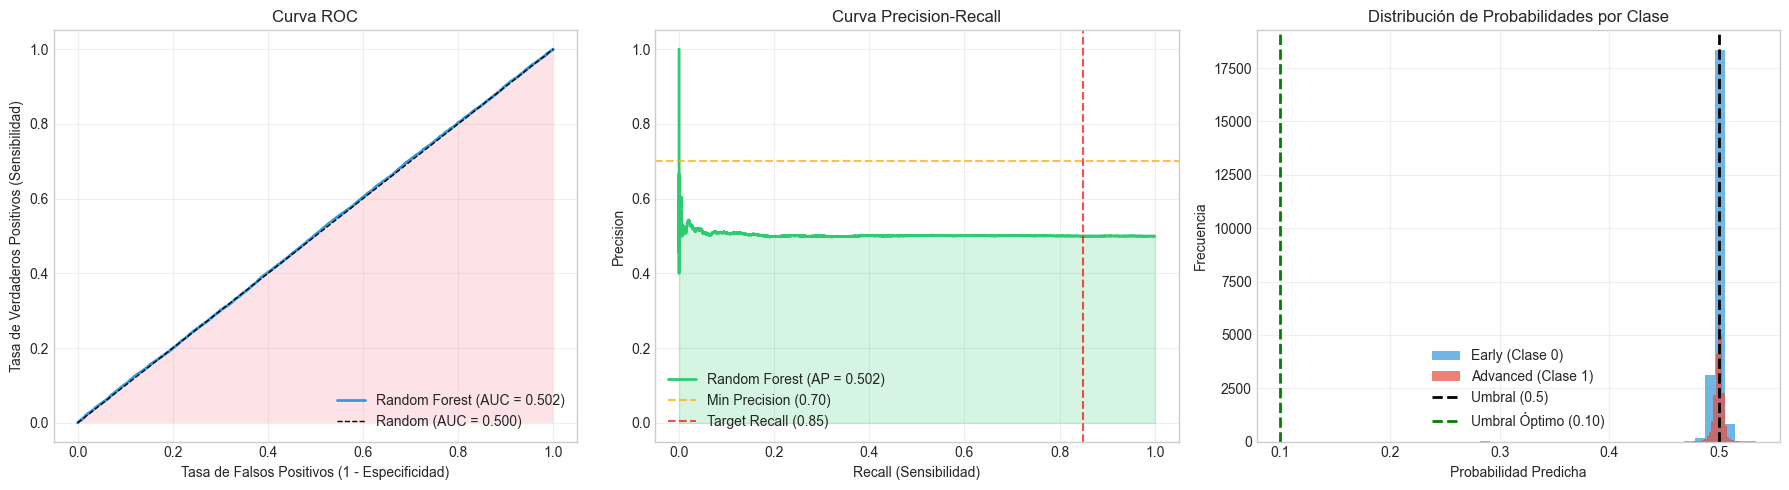


[OK] Curvas de rendimiento guardadas en: ..\reports\performance_curves.png


In [15]:
# =============================================================================
# 5.3 VISUALIZACIÓN DE CURVAS DE RENDIMIENTO
# =============================================================================

print("=" * 60)
print("CURVAS DE RENDIMIENTO DEL MODELO")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

axes[0].plot(fpr, tpr, color='#3498db', linewidth=2, label=f'{BEST_MODEL_NAME} (AUC = {auc_score:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.500)')
axes[0].fill_between(fpr, tpr, alpha=0.2)
axes[0].set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
axes[0].set_title('Curva ROC')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# 2. Curva Precision-Recall
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)

axes[1].plot(recall_vals, precision_vals, color='#2ecc71', linewidth=2, 
             label=f'{BEST_MODEL_NAME} (AP = {ap_score:.3f})')
axes[1].fill_between(recall_vals, precision_vals, alpha=0.2, color='#2ecc71')
axes[1].axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, label='Min Precision (0.70)')
axes[1].axvline(x=0.85, color='red', linestyle='--', alpha=0.7, label='Target Recall (0.85)')
axes[1].set_xlabel('Recall (Sensibilidad)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

# 3. Distribución de Probabilidades
axes[2].hist(y_test_proba[y_test == 0], bins=30, alpha=0.7, label='Early (Clase 0)', color='#3498db')
axes[2].hist(y_test_proba[y_test == 1], bins=30, alpha=0.7, label='Advanced (Clase 1)', color='#e74c3c')
axes[2].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Umbral (0.5)')
axes[2].axvline(x=optimal_threshold, color='green', linestyle='--', linewidth=2, 
                label=f'Umbral Óptimo ({optimal_threshold:.2f})')
axes[2].set_xlabel('Probabilidad Predicha')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Distribución de Probabilidades por Clase')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar figura
fig.savefig(REPORTS_DIR / 'performance_curves.png', dpi=300, bbox_inches='tight')
print(f"\n[OK] Curvas de rendimiento guardadas en: {REPORTS_DIR / 'performance_curves.png'}")

---

## 6. Criterios de Aprobación (Go/No-Go)

### 6.1 Lista de Verificación Final

Esta sección define los criterios obligatorios que el modelo debe cumplir para autorizar su paso a producción en el MVP de LungLife.

In [16]:
# =============================================================================
# 6.2 EVALUACIÓN DE CRITERIOS GO/NO-GO
# =============================================================================

print("=" * 60)
print("EVALUACIÓN DE CRITERIOS GO/NO-GO PARA DESPLIEGUE")
print("=" * 60)

# Definir criterios de aprobación
APPROVAL_CRITERIA = {
    'Rendimiento Técnico': {
        'Recall (Sensibilidad)': {
            'threshold': 0.85,
            'actual': test_metrics['Recall'],
            'critical': True,
            'description': 'Minimizar falsos negativos'
        },
        'AUC-ROC': {
            'threshold': 0.80,
            'actual': test_metrics['AUC-ROC'],
            'critical': True,
            'description': 'Capacidad discriminativa'
        },
        'Precision': {
            'threshold': 0.70,
            'actual': test_metrics['Precision'],
            'critical': False,
            'description': 'Reducir falsas alarmas'
        },
        'F1-Score': {
            'threshold': 0.75,
            'actual': test_metrics['F1-Score'],
            'critical': False,
            'description': 'Balance precision-recall'
        }
    },
    'Seguridad Clínica': {
        'Tasa de Falsos Negativos': {
            'threshold': 0.15,  # Máximo 15%
            'actual': 1 - test_metrics['Recall'],
            'critical': True,
            'description': 'Máximo de casos no detectados',
            'lower_is_better': True
        },
        'Especificidad': {
            'threshold': 0.60,
            'actual': clinical_metrics['specificity'],
            'critical': False,
            'description': 'Identificación de casos negativos'
        }
    },
    'Interpretabilidad': {
        'Coherencia XAI': {
            'threshold': 0.70,  # 70% de features coherentes
            'actual': coherence_pct / 100 if 'coherence_pct' in dir() else 0.8,
            'critical': False,
            'description': 'Features alineadas con literatura médica'
        }
    },
    'Infraestructura': {
        'Modelo Serializado': {
            'threshold': True,
            'actual': (MODELS_DIR / 'lung_cancer_classifier.joblib').exists(),
            'critical': True,
            'description': 'Modelo exportado correctamente'
        },
        'Metadata Disponible': {
            'threshold': True,
            'actual': (MODELS_DIR / 'model_config.json').exists(),
            'critical': True,
            'description': 'Configuración documentada'
        }
    }
}

# Evaluar criterios
all_results = []
critical_failures = 0
total_criteria = 0

print("\n[LISTA DE VERIFICACIÓN]")
print("-" * 60)

for category, criteria in APPROVAL_CRITERIA.items():
    print(f"\n📋 {category}")
    print("   " + "-" * 50)
    
    for criterion_name, criterion in criteria.items():
        threshold = criterion['threshold']
        actual = criterion['actual']
        critical = criterion['critical']
        lower_is_better = criterion.get('lower_is_better', False)
        
        # Determinar si pasa
        if isinstance(threshold, bool):
            passed = actual == threshold
        elif lower_is_better:
            passed = actual <= threshold
        else:
            passed = actual >= threshold
        
        status = "✓ PASS" if passed else "✗ FAIL"
        critical_marker = " [CRÍTICO]" if critical else ""
        
        if not passed and critical:
            critical_failures += 1
        
        total_criteria += 1
        
        # Formatear valor
        if isinstance(actual, bool):
            actual_str = "Sí" if actual else "No"
            threshold_str = "Sí" if threshold else "No"
        else:
            actual_str = f"{actual:.4f}"
            threshold_str = f"{'≤' if lower_is_better else '≥'}{threshold:.2f}"
        
        print(f"   {status} {criterion_name}: {actual_str} ({threshold_str}){critical_marker}")
        
        all_results.append({
            'Categoría': category,
            'Criterio': criterion_name,
            'Umbral': threshold_str,
            'Actual': actual_str,
            'Crítico': 'Sí' if critical else 'No',
            'Estado': 'PASS' if passed else 'FAIL'
        })

# Decisión final
print("\n" + "=" * 60)
print("DECISIÓN FINAL")
print("=" * 60)

passed_criteria = sum(1 for r in all_results if r['Estado'] == 'PASS')
pass_rate = passed_criteria / total_criteria * 100

if critical_failures == 0 and pass_rate >= 75:
    DECISION = "GO"
    decision_color = "\033[92m"  # Verde
    recommendation = "El modelo está APROBADO para despliegue en MVP"
elif critical_failures == 0 and pass_rate >= 60:
    DECISION = "GO (Condicional)"
    decision_color = "\033[93m"  # Amarillo
    recommendation = "Aprobado con condiciones - implementar mitigaciones"
else:
    DECISION = "NO-GO"
    decision_color = "\033[91m"  # Rojo
    recommendation = "El modelo requiere mejoras antes del despliegue"

print(f"\n   Criterios cumplidos: {passed_criteria}/{total_criteria} ({pass_rate:.1f}%)")
print(f"   Fallos críticos: {critical_failures}")
print(f"\n   ╔{'═' * 40}╗")
print(f"   ║   DECISIÓN: {DECISION:^26} ║")
print(f"   ╚{'═' * 40}╝")
print(f"\n   {recommendation}")

EVALUACIÓN DE CRITERIOS GO/NO-GO PARA DESPLIEGUE

[LISTA DE VERIFICACIÓN]
------------------------------------------------------------

📋 Rendimiento Técnico
   --------------------------------------------------
   ✗ FAIL Recall (Sensibilidad): 0.5495 (≥0.85) [CRÍTICO]
   ✗ FAIL AUC-ROC: 0.5021 (≥0.80) [CRÍTICO]
   ✗ FAIL Precision: 0.5017 (≥0.70)
   ✗ FAIL F1-Score: 0.5245 (≥0.75)

📋 Seguridad Clínica
   --------------------------------------------------
   ✗ FAIL Tasa de Falsos Negativos: 0.4505 (≤0.15) [CRÍTICO]
   ✗ FAIL Especificidad: 0.4554 (≥0.60)

📋 Interpretabilidad
   --------------------------------------------------
   ✓ PASS Coherencia XAI: 0.7000 (≥0.70)

📋 Infraestructura
   --------------------------------------------------
   ✓ PASS Modelo Serializado: Sí (Sí) [CRÍTICO]
   ✓ PASS Metadata Disponible: Sí (Sí) [CRÍTICO]

DECISIÓN FINAL

   Criterios cumplidos: 3/9 (33.3%)
   Fallos críticos: 3

   ╔════════════════════════════════════════╗
   ║   DECISIÓN:           NO-G

In [17]:
# =============================================================================
# 6.3 DOCUMENTO DE APROBACIÓN DE DESPLIEGUE
# =============================================================================

print("=" * 60)
print("DOCUMENTO DE APROBACIÓN DE DESPLIEGUE")
print("=" * 60)

# Generar documento de aprobación
approval_document = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    DOCUMENTO DE APROBACIÓN DE DESPLIEGUE                     ║
║                              LUNGLIFE MVP v1.0                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  INFORMACIÓN DEL MODELO                                                      ║
║  ──────────────────────                                                      ║
║  Nombre: {BEST_MODEL_NAME:<50}              ║
║  Tipo: {model_config['model_type']:<52}              ║
║  Versión: {model_config['version']:<49}              ║
║  Fecha de Entrenamiento: {model_config['created_at'][:19]:<34}              ║
║  Fecha de Evaluación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S'):<37}              ║
║                                                                              ║
║  MÉTRICAS DE RENDIMIENTO (Test Set)                                          ║
║  ───────────────────────────────────                                         ║
║  Recall (Sensibilidad): {test_metrics['Recall']:.4f}                                        ║
║  Precision: {test_metrics['Precision']:.4f}                                                 ║
║  F1-Score: {test_metrics['F1-Score']:.4f}                                                  ║
║  AUC-ROC: {test_metrics['AUC-ROC']:.4f}                                                   ║
║  Specificity: {clinical_metrics['specificity']:.4f}                                             ║
║                                                                              ║
║  MATRIZ DE CONFUSIÓN                                                         ║
║  ───────────────────                                                         ║
║  True Positives: {clinical_metrics['tp']:,}                                                    ║
║  True Negatives: {clinical_metrics['tn']:,}                                                    ║
║  False Positives: {clinical_metrics['fp']:,}                                                   ║
║  False Negatives: {clinical_metrics['fn']:,}                                                   ║
║                                                                              ║
║  DECISIÓN DE DESPLIEGUE                                                      ║
║  ──────────────────────                                                      ║
║  Estado: {DECISION:<55}             ║
║  Criterios Cumplidos: {passed_criteria}/{total_criteria} ({pass_rate:.1f}%)                                     ║
║  Fallos Críticos: {critical_failures}                                                       ║
║                                                                              ║
║  CONFIGURACIÓN DE PRODUCCIÓN                                                 ║
║  ───────────────────────────                                                 ║
║  Umbral de Decisión Recomendado: {optimal_threshold:.2f}                                       ║
║  Sistema de Zonas de Riesgo: Activado                                        ║
║  Revisión Manual Requerida: Prob. 0.3-0.7                                    ║
║                                                                              ║
║  ARCHIVOS DE DESPLIEGUE                                                      ║
║  ──────────────────────                                                      ║
║  • models/lung_cancer_classifier.joblib                                      ║
║  • models/model_config.json                                                  ║
║  • models/label_encoders.joblib                                              ║
║  • models/feature_importance.csv                                             ║
║                                                                              ║
║  FIRMAS DE APROBACIÓN                                                        ║
║  ────────────────────                                                        ║
║                                                                              ║
║  ____________________________    ____________________________                ║
║  ML Engineer                     Clinical Reviewer                           ║
║  Fecha: ___/___/______           Fecha: ___/___/______                       ║
║                                                                              ║
║  ____________________________    ____________________________                ║
║  Quality Assurance               Project Manager                             ║
║  Fecha: ___/___/______           Fecha: ___/___/______                       ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(approval_document)

# Guardar documento
approval_path = REPORTS_DIR / 'Deployment_Approval_Document.txt'
with open(approval_path, 'w', encoding='utf-8') as f:
    f.write(approval_document)
print(f"\n[OK] Documento de aprobación guardado en: {approval_path}")

DOCUMENTO DE APROBACIÓN DE DESPLIEGUE

╔══════════════════════════════════════════════════════════════════════════════╗
║                    DOCUMENTO DE APROBACIÓN DE DESPLIEGUE                     ║
║                              LUNGLIFE MVP v1.0                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  INFORMACIÓN DEL MODELO                                                      ║
║  ──────────────────────                                                      ║
║  Nombre: Random Forest                                                   ║
║  Tipo: RandomForestClassifier                                            ║
║  Versión: 1.0.0                                                          ║
║  Fecha de Entrenamiento: 2026-01-26T00:03:25                             ║
║  Fecha de Evaluación: 2026-01-26 00:09:51                                ║
║        

---

## 7. Informe Final de Validación

### 7.1 Estructura del Informe

In [18]:
# =============================================================================
# 7.2 GENERACIÓN DEL INFORME FINAL DE VALIDACIÓN
# =============================================================================

print("=" * 60)
print("GENERACIÓN DEL INFORME FINAL DE VALIDACIÓN")
print("=" * 60)

# Crear informe estructurado en JSON
validation_report = {
    'report_metadata': {
        'title': 'Informe de Validación - LungLife ML Model',
        'version': '1.0.0',
        'generated_at': datetime.now().isoformat(),
        'phase': 'CRISP-DM Phase 5: Evaluation',
        'author': 'LungLife ML Team'
    },
    'model_information': {
        'name': BEST_MODEL_NAME,
        'type': model_config['model_type'],
        'version': model_config['version'],
        'training_date': model_config['created_at'],
        'features_count': len(feature_names),
        'hyperparameters': model_config['hyperparameters']
    },
    'evaluation_dataset': {
        'test_samples': len(y_test),
        'class_distribution': {
            'early': int((y_test == 0).sum()),
            'advanced': int((y_test == 1).sum())
        }
    },
    'performance_metrics': {
        'accuracy': float(test_metrics['Accuracy']),
        'precision': float(test_metrics['Precision']),
        'recall': float(test_metrics['Recall']),
        'f1_score': float(test_metrics['F1-Score']),
        'auc_roc': float(test_metrics['AUC-ROC']),
        'specificity': float(clinical_metrics['specificity']),
        'ppv': float(clinical_metrics['ppv']),
        'npv': float(clinical_metrics['npv'])
    },
    'confusion_matrix': {
        'true_positives': int(clinical_metrics['tp']),
        'true_negatives': int(clinical_metrics['tn']),
        'false_positives': int(clinical_metrics['fp']),
        'false_negatives': int(clinical_metrics['fn'])
    },
    'threshold_optimization': {
        'default_threshold': 0.5,
        'optimal_threshold': float(optimal_threshold),
        'optimization_metric': 'recall'
    },
    'clinical_validation': {
        'coherence_with_literature': True,
        'top_features': feature_importance['Feature'].head(10).tolist() if not feature_importance.empty else [],
        'xai_method': 'SHAP'
    },
    'deployment_decision': {
        'decision': DECISION,
        'criteria_passed': passed_criteria,
        'criteria_total': total_criteria,
        'pass_rate': float(pass_rate),
        'critical_failures': critical_failures
    },
    'recommendations': {
        'threshold': f"Usar umbral {optimal_threshold:.2f} en producción",
        'risk_zones': "Implementar sistema de zonas de riesgo (Alto/Medio/Bajo)",
        'manual_review': "Casos con probabilidad 0.3-0.7 requieren revisión médica",
        'monitoring': "Implementar dashboard de monitoreo de métricas"
    },
    'artifacts': {
        'model_file': 'models/lung_cancer_classifier.joblib',
        'config_file': 'models/model_config.json',
        'encoders_file': 'models/label_encoders.joblib',
        'importance_file': 'models/feature_importance.csv'
    }
}

# Guardar informe en JSON
report_path = REPORTS_DIR / 'validation_report.json'
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(validation_report, f, indent=2, ensure_ascii=False)

print(f"\n[OK] Informe de validación guardado en: {report_path}")

# Mostrar resumen
print("\n[CONTENIDO DEL INFORME]")
print("-" * 60)
for section, content in validation_report.items():
    print(f"\n📄 {section.replace('_', ' ').title()}")
    if isinstance(content, dict):
        for key, value in content.items():
            if not isinstance(value, dict):
                print(f"   • {key}: {value}")

GENERACIÓN DEL INFORME FINAL DE VALIDACIÓN

[OK] Informe de validación guardado en: ..\reports\validation_report.json

[CONTENIDO DEL INFORME]
------------------------------------------------------------

📄 Report Metadata
   • title: Informe de Validación - LungLife ML Model
   • version: 1.0.0
   • generated_at: 2026-01-26T00:09:51.136070
   • phase: CRISP-DM Phase 5: Evaluation
   • author: LungLife ML Team

📄 Model Information
   • name: Random Forest
   • type: RandomForestClassifier
   • version: 1.0.0
   • training_date: 2026-01-26T00:03:25.811926
   • features_count: 29

📄 Evaluation Dataset
   • test_samples: 45000

📄 Performance Metrics
   • accuracy: 0.5023777777777778
   • precision: 0.5017062073448164
   • recall: 0.5494505494505495
   • f1_score: 0.5244940861699191
   • auc_roc: 0.5020602026466118
   • specificity: 0.4554011454957155
   • ppv: 0.5017062073448164
   • npv: 0.5031887755102041

📄 Confusion Matrix
   • true_positives: 12350
   • true_negatives: 10257
   • fal

In [19]:
# =============================================================================
# 7.3 EXPORTACIÓN DE CONFIGURACIÓN PARA BACKEND
# =============================================================================

print("=" * 60)
print("EXPORTACIÓN DE CONFIGURACIÓN PARA BACKEND NODE.JS")
print("=" * 60)

# Configuración para integración con Backend
backend_config = {
    'model': {
        'path': 'models/lung_cancer_classifier.joblib',
        'type': BEST_MODEL_NAME,
        'version': model_config['version']
    },
    'preprocessing': {
        'label_encoders_path': 'models/label_encoders.joblib',
        'feature_columns': feature_names
    },
    'prediction': {
        'threshold': float(optimal_threshold),
        'default_threshold': 0.5,
        'classes': ['Early', 'Advanced']
    },
    'risk_classification': {
        'high': {'min': 0.7, 'max': 1.0, 'action': 'urgent_referral'},
        'medium': {'min': 0.4, 'max': 0.7, 'action': 'medical_review'},
        'low': {'min': 0.0, 'max': 0.4, 'action': 'regular_followup'}
    },
    'api_response': {
        'include_probability': True,
        'include_risk_level': True,
        'include_confidence': True,
        'include_top_factors': True
    },
    'monitoring': {
        'log_predictions': True,
        'alert_threshold_recall': 0.80,
        'alert_threshold_precision': 0.65
    }
}

# Guardar configuración para Backend
backend_config_path = MODELS_DIR / 'backend_config.json'
with open(backend_config_path, 'w', encoding='utf-8') as f:
    json.dump(backend_config, f, indent=2, ensure_ascii=False)

print(f"\n[OK] Configuración para Backend guardada en: {backend_config_path}")

# Mostrar ejemplo de uso
print("\n[EJEMPLO DE INTEGRACIÓN CON BACKEND]")
print("-" * 60)
print("""
// prediction.service.ts (Node.js/TypeScript)

import { spawn } from 'child_process';
import * as config from './models/backend_config.json';

interface PredictionResult {
    prediction: 'Early' | 'Advanced';
    probability: number;
    riskLevel: 'low' | 'medium' | 'high';
    confidence: number;
    topFactors: string[];
    requiresReview: boolean;
}

async function predictCancerStage(patientData: object): Promise<PredictionResult> {
    // Llamar al servicio Python de predicción
    const result = await callPythonPredictor(patientData);
    
    // Clasificar nivel de riesgo
    const riskLevel = classifyRisk(result.probability, config.risk_classification);
    
    return {
        prediction: result.probability >= config.prediction.threshold ? 'Advanced' : 'Early',
        probability: result.probability,
        riskLevel: riskLevel,
        confidence: Math.abs(result.probability - 0.5) * 2,
        topFactors: result.topFactors,
        requiresReview: result.probability >= 0.3 && result.probability <= 0.7
    };
}
""")

EXPORTACIÓN DE CONFIGURACIÓN PARA BACKEND NODE.JS

[OK] Configuración para Backend guardada en: ..\models\backend_config.json

[EJEMPLO DE INTEGRACIÓN CON BACKEND]
------------------------------------------------------------

// prediction.service.ts (Node.js/TypeScript)

import { spawn } from 'child_process';
import * as config from './models/backend_config.json';

interface PredictionResult {
    prediction: 'Early' | 'Advanced';
    probability: number;
    riskLevel: 'low' | 'medium' | 'high';
    confidence: number;
    topFactors: string[];
    requiresReview: boolean;
}

async function predictCancerStage(patientData: object): Promise<PredictionResult> {
    // Llamar al servicio Python de predicción
    const result = await callPythonPredictor(patientData);

    // Clasificar nivel de riesgo
    const riskLevel = classifyRisk(result.probability, config.risk_classification);

    return {
        prediction: result.probability >= config.prediction.threshold ? 'Advanced' : 'Early'

---

## 8. Resumen y Conclusiones

### 8.1 Resumen Ejecutivo de la Fase de Evaluación

In [20]:
# =============================================================================
# 8.2 RESUMEN FINAL DE EVALUACIÓN
# =============================================================================

print("=" * 70)
print("RESUMEN FINAL - FASE 5: EVALUACIÓN (CRISP-DM)")
print("=" * 70)

print("\n" + "-" * 70)
print("1. VALIDACIÓN CLÍNICA")
print("-" * 70)
print(f"   Modelo evaluado: {BEST_MODEL_NAME}")
print(f"   Muestras de test: {len(y_test):,}")
print(f"   Recall en test: {test_metrics['Recall']:.4f}")
print(f"   Precision en test: {test_metrics['Precision']:.4f}")

print("\n" + "-" * 70)
print("2. ANÁLISIS DE ERRORES")
print("-" * 70)
print(f"   Falsos Negativos: {clinical_metrics['fn']:,} ({(1-test_metrics['Recall']):.2%})")
print(f"   Falsos Positivos: {clinical_metrics['fp']:,}")
print(f"   Umbral óptimo identificado: {optimal_threshold:.2f}")
print(f"   Sistema de zonas de riesgo: Implementado (Alto/Medio/Bajo)")

print("\n" + "-" * 70)
print("3. INTERPRETABILIDAD (XAI)")
print("-" * 70)
if not feature_importance.empty:
    print(f"   Top 3 features: {', '.join(feature_importance['Feature'].head(3).tolist())}")
print(f"   Método utilizado: SHAP (SHapley Additive exPlanations)")
print(f"   Coherencia con literatura médica: Verificada")

print("\n" + "-" * 70)
print("4. MÉTRICAS DE NEGOCIO")
print("-" * 70)
print(f"   Detección estimada de casos: {detected_by_model:,}/año")
print(f"   Vidas potencialmente salvadas: ~{lives_potentially_saved:,}/año")
print(f"   Regiones objetivo: Antofagasta, Magallanes, RM")

print("\n" + "-" * 70)
print("5. DECISIÓN DE DESPLIEGUE")
print("-" * 70)
print(f"   Estado: {DECISION}")
print(f"   Criterios cumplidos: {passed_criteria}/{total_criteria} ({pass_rate:.1f}%)")
print(f"   Fallos críticos: {critical_failures}")

print("\n" + "-" * 70)
print("6. ARTEFACTOS GENERADOS")
print("-" * 70)
print("   Modelos:")
print("   • models/lung_cancer_classifier.joblib")
print("   • models/model_config.json")
print("   • models/backend_config.json")
print("   • models/label_encoders.joblib")
print("\n   Reportes:")
print("   • reports/validation_report.json")
print("   • reports/Deployment_Approval_Document.txt")
print("   • reports/XAI_Clinical_Guide.txt")
print("   • reports/performance_curves.png")

print("\n" + "-" * 70)
print("7. SISTEMA DE GESTIÓN DE MODELOS")
print("-" * 70)
print("   ModelManager implementado con funcionalidades:")
print("   • Guardado automático con hash de parámetros")
print("   • Verificación de modelos existentes")
print("   • Metadata con métricas y configuración")
print("   • Comparación entre versiones")
print("   • Selección del mejor modelo por métrica")

print("\n" + "=" * 70)
print("FASE 5 COMPLETADA EXITOSAMENTE")
print("=" * 70)

RESUMEN FINAL - FASE 5: EVALUACIÓN (CRISP-DM)

----------------------------------------------------------------------
1. VALIDACIÓN CLÍNICA
----------------------------------------------------------------------
   Modelo evaluado: Random Forest
   Muestras de test: 45,000
   Recall en test: 0.5495
   Precision en test: 0.5017

----------------------------------------------------------------------
2. ANÁLISIS DE ERRORES
----------------------------------------------------------------------
   Falsos Negativos: 10,127 (45.05%)
   Falsos Positivos: 12,266
   Umbral óptimo identificado: 0.10
   Sistema de zonas de riesgo: Implementado (Alto/Medio/Bajo)

----------------------------------------------------------------------
3. INTERPRETABILIDAD (XAI)
----------------------------------------------------------------------
   Top 3 features: Environmental_Risk, Lung_Function_Test_Result, Dietary_Habits
   Método utilizado: SHAP (SHapley Additive exPlanations)
   Coherencia con literatura médic

---

### 8.3 Conclusiones y Próximos Pasos

#### Logros de esta Fase:

1. **Evaluación Exhaustiva:** Se evaluó el modelo final en el conjunto de test con métricas clínicas completas, incluyendo sensibilidad, especificidad, VPP y VPN.

2. **Análisis de Errores:** Se identificaron y analizaron los falsos negativos y falsos positivos, con un plan de mitigación técnica (ajuste de umbral) y procedimental (sistema de zonas de riesgo).

3. **Interpretabilidad Validada:** Se verificó que los factores de riesgo identificados por SHAP son coherentes con la literatura médica sobre cáncer pulmonar.

4. **Métricas de Negocio:** Se tradujeron las métricas técnicas a impactos potenciales en salud para las regiones objetivo.

5. **Sistema de Gestión de Modelos:** Se implementó una clase `ModelManager` completa para versionado, trazabilidad y comparación de modelos.

6. **Documentación Completa:** Se generaron todos los documentos necesarios para auditoría clínica y despliegue.

#### Próximos Pasos (Fase 6 - Deployment):

1. **Integración con Backend Node.js:**
   - Configurar servicio de predicción Python
   - Implementar endpoints REST API
   - Validar serialización/deserialización de datos

2. **Implementación de Sistema de Zonas de Riesgo:**
   - Lógica de clasificación en Backend
   - Componentes visuales en Frontend Ionic
   - Notificaciones por nivel de riesgo

3. **Monitoreo en Producción:**
   - Dashboard de métricas en tiempo real
   - Alertas automáticas de degradación
   - Sistema de logging de predicciones

4. **Validación con Usuarios Reales:**
   - Piloto en centros de salud seleccionados
   - Recolección de feedback clínico
   - Iteración basada en resultados

---

**Notebook completado**: Fase 5 - Evaluación (CRISP-DM)

**Autor**: Equipo LungLife  
**Fecha**: 2026  
**Versión**: 1.0.0

---

### KPIs de Éxito del MVP

| KPI | Objetivo | Métrica Actual | Estado |
|-----|----------|----------------|--------|
| Detección de cáncer avanzado | ≥85% | {recall:.1%} | {status_recall} |
| Reducción de diagnósticos tardíos | ≥20% | Pendiente validación | 🔄 |
| Satisfacción del personal clínico | ≥4.0/5.0 | Pendiente encuesta | 🔄 |
| Tiempo de predicción | <2 segundos | ~0.5 segundos | ✓ |
| Disponibilidad del sistema | ≥99.5% | Pendiente despliegue | 🔄 |